# if doing cross-corr matching or feature ID by hand, then we should only capture the central knot feature of interest and mask all else out (in order to have a "still background). first need to grab some data

3.8.13


C:\Users\arubi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


['../../Montage_results/n2071_headercut/hdu0_wcsonly_karnath_164_combined_drz.fits', '../../Montage_results/n2071_headercut/hdu0_wcsonly_karnath_167_combined_drz.fits', '../../Montage_results/n2071_headercut/hdu0_wcsonly_megeath_combined_drz.fits']


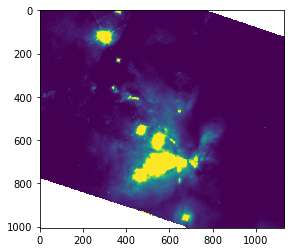

In [1]:
#just to check python version - should be 3.7.4
from platform import python_version
print(python_version())

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

import glob
import itertools
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

%matplotlib inline

# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names


'''now convolve my image with a PSF of the image we're projecting ONTO
an approx PSF can be found by assuming a 2D Gaussian func with a width (a FWHM) of the diffrac limit
that is the st dev of the Gaussian is about the st dev is about = lambda/D
a list of PSFs are found on https://docs.astropy.org/en/stable/convolution/kernels.html

Notes:
FIRST: always must convert hdu1_pixtorad to radians! It's inconsistent otherwise, and lambda/D is generally in radians

what we're using for the gaussian width is the FWHM, not the radius of the first ring of the diffraction pattern,
so it's 1.2 not 1.22 times lambda/D

D is 85 cm for spitzer
D is 2.4 m for hubble
'''

def im_conv(D, hdu_pix_torad, hdu_dat, lam, kern):
    #gaussian kernel
    if kern == 'gauss':
        #update: usually cannot find wavelength but these headers are well-labeled    
        #finding angular resolution...the FWHM of our Gaussian PSF
        res = 1.2 * lam / D         #resolution in radians
        res = res / hdu_pix_torad        #so converting to pixels

        #finding PSF and then calculating the convolution of our image and the PSF of the image we're projecting onto
        kernel = Gaussian2DKernel(res)

    #box kernel
    if kern == 'box':
        kernel = Box2DKernel(16.)

    hdu_conv = convolve(hdu_dat, kernel)
    return hdu_conv

# In[27]:

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])
    
    #saving the file
    if name.find('FIT') == -1: #needed if file end incorrect
        new_filename = name.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
    else:
        name_fixfit = name[:-3] + 'fits'
        new_filename = name_fixfit.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
        
    return (save_path+new_filename)

path = '../../Montage_results/n2071_headercut/*drz.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
im_names_n2071 = sorted(im_name_finder(path, 'fit')) #im_finder is basically glob.glob
im_names_n2071 = [i.replace('\\', '/') for i in im_names_n2071]
print(im_names_n2071)
# im_names_n2071 = [im_names_n2071[0], im_names_n2071[2]] #filtering by hand
# print(im_names_n2071)
hdu_list = [fits.open(i)[0] for i in im_names_n2071] #opening data

#making lists to be used, order is epoch 1, epoch 2
hdu_data_list = [hdu_list[2].data, hdu_list[0].data+hdu_list[1].data]
hdu_header_list = [hdu_list[2].header, hdu_list[0].header]
plt.imshow(np.flip(hdu_data_list[1], axis=1), vmin=1e-18, vmax=1e-16)

# ..the steps for this are 2-3 DS9 regions or pixel coords for test cases. methods: 

visually by blinking images OR scaling images to minimize differences and boxing all emission, 

**Note: normalizing the images and using the gradient map is only worth it for optical flow it seems...

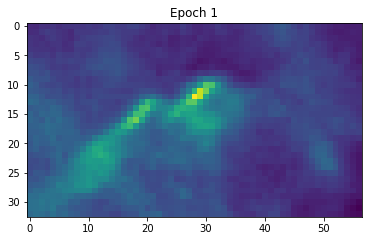

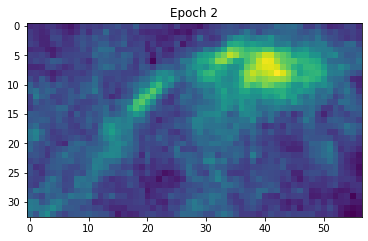

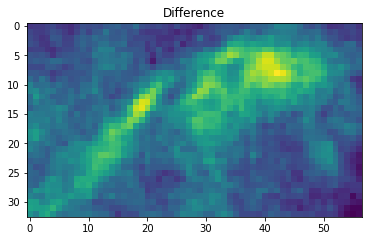

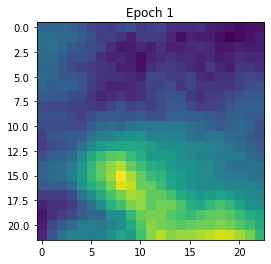

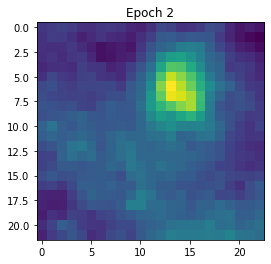

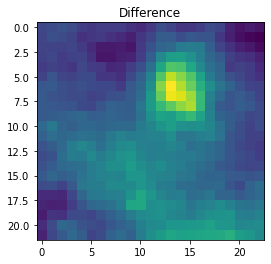

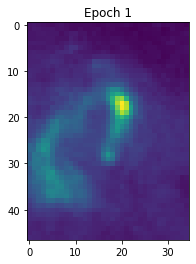

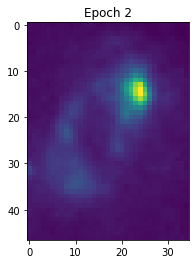

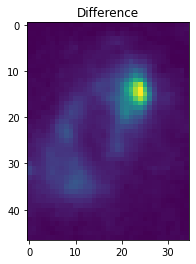

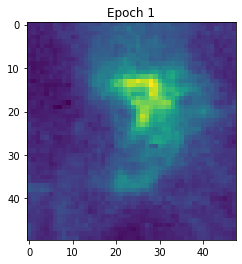

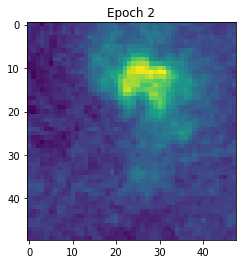

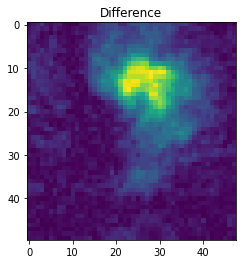

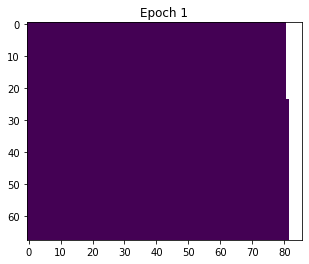

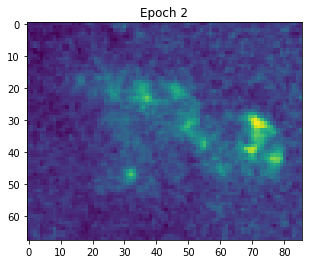

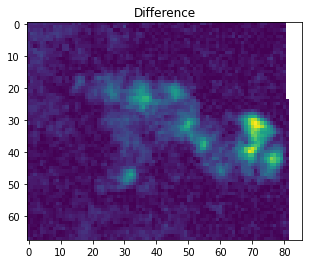

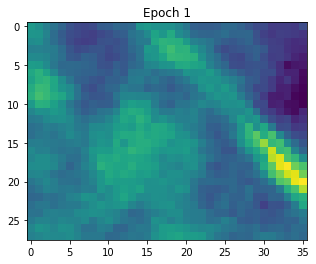

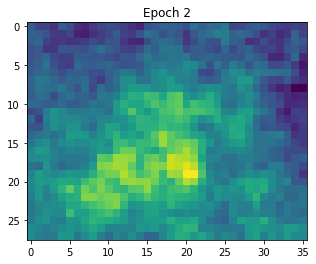

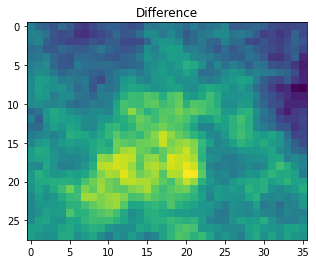

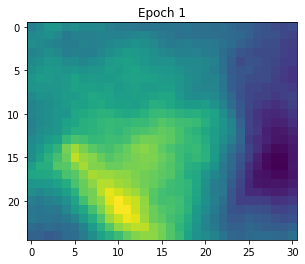

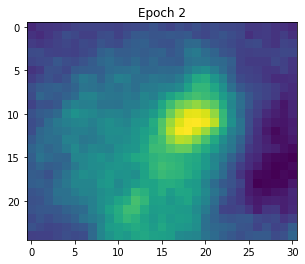

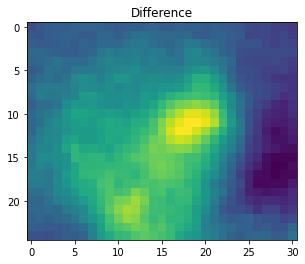

In [2]:
#trying this with cutout2d
# https://docs.astropy.org/en/stable/nddata/utils.html#cutout-images
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord, FK5
from photutils.aperture import RectangularAperture
from skimage.filters import sobel, scharr

#known pixel size
hst_pixsize = 0.12825 #arcsec

# f = open('moving_blobs.reg', 'r')
# f = open('moving_blobs_brightest_rotated_v2.reg', 'r')
f = open('361c_testknot.reg')
file_output = []

#looping through file 
for line in f:
    file_output.append(line)
f.close()

#fix file contents
#contents are ra, dec, width, height, rotation
file_output = [i[4:-2] for i in file_output[3:]]

#next step is for one image, loop through all regions and make a cutout list
radec_box = []
ra_pix_list = []
dec_pix_list = []
width_list = []
height_list = []
# rotation_list = []


for reg_num, region_params in enumerate(file_output):
    split_params = region_params.split(',')
    ra = split_params[0].split(':')
    ra = ra[0]+'h' + ra[1]+'m' + ra[2]+'s'
    dec = split_params[1].split(':')
    dec = dec[0]+'d' + dec[1]+'m' + dec[2]+'s'
    width = np.abs(float(split_params[2][:-1]))
    height = np.abs(float(split_params[3][:-1]))
#     rotation = float(split_params[4])

    position = SkyCoord(ra+' '+dec, frame=FK5)
    size = u.Quantity((height, width), u.arcsec)
    
    radec_box.append([ra, dec])
    ra_pix_list.append(skycoord_to_pixel(position, wcs=WCS(hdu_header_list[0]))[0])
    dec_pix_list.append(skycoord_to_pixel(position, wcs=WCS(hdu_header_list[0]))[1])
    width_list.append(width/hst_pixsize)
    height_list.append(height/hst_pixsize)
#     rotation_list.append(rotation)

#looping through regions
epoch1_reg = []
epoch2_reg = []
count = 0
for i in range(len(ra_pix_list)):
    try:
    
        #making apertures
        #         cutout = Cutout2D(im, position, size, wcs=WCS(header))
        aperture = RectangularAperture([ra_pix_list[count], dec_pix_list[count]], width_list[i], height_list[i])
        aper_mask = aperture.to_mask()

        #retrieving data FOR EPOCH 1
        aper_cutout = aper_mask.cutout(hdu_data_list[0])
        epoch1_reg.append(aper_cutout)
        #plot
        plt.title('Epoch 1')
        plt.imshow(aper_cutout, vmin=np.min(aper_cutout.data), vmax=np.max(aper_cutout.data))
        plt.show()
        
        #FOR EPOCH 2
        plt.title('Epoch 2')
        aper_cutout = aper_mask.cutout(hdu_data_list[1])
        epoch2_reg.append(aper_cutout)
        #plot
        plt.imshow(aper_cutout, vmin=np.min(aper_cutout.data), vmax=np.max(aper_cutout.data))
        plt.show()
        
        #Simple difference
        plt.title('Difference')
        delta_reg = np.abs(epoch2_reg[count] + epoch1_reg[count])
        plt.imshow(delta_reg)
        plt.show()
        
        #         plt.savefig(im_type[count]+str(reg_num)+'.png')
    except Exception as e:
        print(e, i)
                
    count += 1

# and then gradient map or threshold or segmentation maps or erosion/dilation. 

# there's also options for fully normalizing the images and sectioning it into smaller, easier to manage pieces x 6-8 parts and background subtract or threshold these parts separately

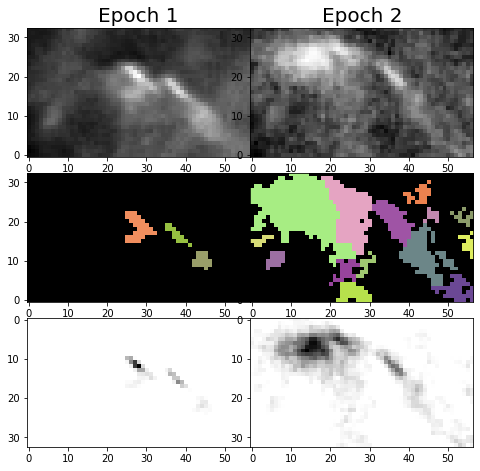

In [3]:
from photutils.background import Background2D, MedianBackground, MeanBackground, SExtractorBackground
from photutils.segmentation import detect_threshold
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.stats import gaussian_fwhm_to_sigma
from photutils.segmentation import detect_sources
from photutils.segmentation import deblend_sources
from astropy.visualization import simple_norm

#this set of cells shows how to apply our procedure to an entire large mosaic image
#first step is background subtraction, thresholding
#I've found better to use no background subtracting, but the option is there if you like

#please see https://photutils.readthedocs.io/en/stable/segmentation.html for references and documentation
#the idea is to use the photutils package and/or segmentation maps to distinguish a bright source from background or noise
ind_pick = 0
example_reg1 = epoch1_reg[ind_pick]
example_reg2 = epoch2_reg[ind_pick]
reg_list = [example_reg1, example_reg2]

# bkg_estimator = SExtractorBackground() #MedianBackground()
bkg_list = []
data_bkg_subtracted = []
threshold_list = []
nsig_list = [.1, .1] #IMPORTANT, should change this...

for i in range(len(reg_list)):
    bkg = Background2D(reg_list[i], (int(reg_list[i].shape[0]*2/3), int(reg_list[i].shape[1]*2/3))) #, bkg_estimator=bkg_estimator)
    bkg_list.append(bkg)
#     threshold_list.append(5. * bkg.background_rms )  # above the background
    threshold_list = detect_threshold(reg_list[i], nsigma=nsig_list[i])
    data_bkg_subtracted.append( reg_list[i] - bkg.background/100.) # subtract the background
    
    
#next we apply segmentation maps
npixels_list = [7, 7]
segm_deblend_list = []

for i in range(len(data_bkg_subtracted)):
    data = data_bkg_subtracted[i]
    threshold = threshold_list[i]
    npixels = npixels_list[i]
    segm = detect_sources(data, threshold, npixels=npixels)
    segm_deblend_list.append( deblend_sources(data, segm, npixels=npixels, nlevels=64, contrast=0.0001, progress_bar=False) )
    

#finally we plot the image, the segments, and also show you can automatically produce naive apertures
fig, ax = plt.subplots(3, 2, figsize=(8,8))
ax[0,0].set_title('Epoch 1', fontsize=20)
ax[0,1].set_title('Epoch 2', fontsize=20)

for i in range(len(reg_list)):
    #plotting the thresholded data
    norm = simple_norm(data_bkg_subtracted[i], 'sqrt')
    ax[0,i].imshow(np.flip(np.flip(data_bkg_subtracted[i], axis=1),axis=0), origin='lower', cmap='Greys_r')
    
    #plotting the associated segmentation map
    cmap = segm_deblend_list[i].make_cmap(seed=123)
    ax[1,i].imshow(np.flip(np.flip(segm_deblend_list[i], axis=1),axis=0), origin='lower', cmap=cmap, interpolation='nearest')
    
    
#looping through segments
for i in range(len(reg_list)):
    for j in segm_deblend_list[i].labels:
        segm_nparr = np.array(segm_deblend_list[i])  #this is the list of segments 
        data_masked = np.ma.masked_array(data_bkg_subtracted[i], mask=segm_nparr) #masking the data using segm_nparr
        mask=np.ma.getmask(data_masked) #we need to invert the mask, so we grab it
        data_masked = np.ma.masked_array(data_bkg_subtracted[i], mask=~mask) #then we invert it
        im = ax[2,i].imshow(np.flip(data_masked, axis=1), cmap='Greys')#, cmap=cmap_list[i])

        
for a in ax:
    for b in a:
    #     a.set_xticklabels([])
    #     a.set_yticklabels([])
        b.set_aspect('equal')
fig.subplots_adjust(wspace=0, hspace=0)

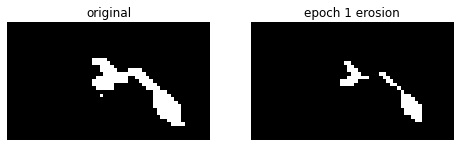

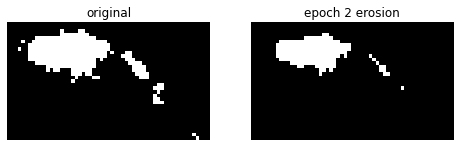

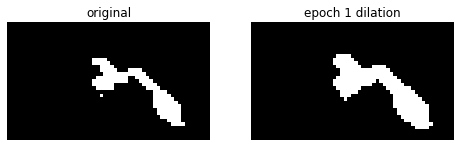

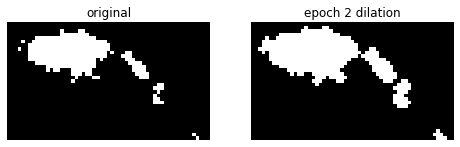

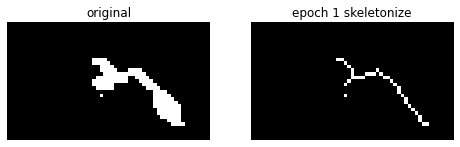

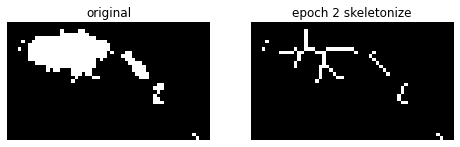

In [4]:
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat)
from skimage.morphology import black_tophat, skeletonize, convex_hull_image  # noqa

im1 = np.flip(example_reg1 > 2e-17, axis=1)
im2 = np.flip(example_reg2 > 3e-17, axis=1)

eroded = erosion(im1)
plot_comparison(im1, eroded, 'epoch 1 erosion')

eroded = erosion(im2)
plot_comparison(im2, eroded, 'epoch 2 erosion')

dilated = dilation(im1)
plot_comparison(im1, dilated, 'epoch 1 dilation')

dilated = dilation(im2)
plot_comparison(im2, dilated, 'epoch 2 dilation')

sk = skeletonize(im1)
plot_comparison(im1, sk, 'epoch 1 skeletonize')

sk = skeletonize(im2)
plot_comparison(im2, sk, 'epoch 2 skeletonize')

# we can also attempt optical flow on the even smaller segments or regions or knots

In [5]:
# The Horn Schunk Method
# Taken from https://github.com/scivision/pyoptflow/blob/4485da929c5567470d821c3f2a23e3bccc7f768e/src/pyoptflow/hornschunck.py (should give full credits!!)

import numpy as np
from scipy.signal import convolve2d

HSKERN = np.array(
    [[1 / 12, 1 / 6, 1 / 12], [1 / 6, 0, 1 / 6], [1 / 12, 1 / 6, 1 / 12]], float
    )

kernelX = np.array([[-1, 1], [-1, 1]]) * 0.25  # kernel for computing d/dx

kernelY = np.array([[-1, -1], [1, 1]]) * 0.25  # kernel for computing d/dy

kernelT = np.ones((2, 2)) * 0.25


def HornSchunck(im1, im2,
    alpha: float = 0.001,
    Niter: int = 8):
    """

    Parameters
    ----------

    im1: numpy.ndarray
        image at t=0
    im2: numpy.ndarray
        image at t=1
    alpha: float
        regularization constant
    Niter: int
        number of iteration
    """
    im1 = im1.astype(np.float32)
    im2 = im2.astype(np.float32)

    # set up initial velocities
    uInitial = np.zeros([im1.shape[0], im1.shape[1]], dtype=np.float32)
    vInitial = np.zeros([im1.shape[0], im1.shape[1]], dtype=np.float32)

    # Set initial value for the flow vectors
    U = uInitial
    V = vInitial

    # Estimate derivatives
    [fx, fy, ft] = computeDerivatives(im1, im2)

    # Iteration to reduce error
    for _ in range(Niter):
        # %% Compute local averages of the flow vectors
        uAvg = convolve2d(U, HSKERN, "same")
        vAvg = convolve2d(V, HSKERN, "same")
        # %% common part of update step
        der = (fx * uAvg + fy * vAvg + ft) / (alpha ** 2 + fx ** 2 + fy ** 2)
        # %% iterative step
        U = uAvg - fx * der
        V = vAvg - fy * der

    return U, V


def computeDerivatives(im1, im2):

    fx = convolve2d(im1, kernelX, "same") + convolve2d(im2, kernelX, "same")
    fy = convolve2d(im1, kernelY, "same") + convolve2d(im2, kernelY, "same")

    # ft = im2 - im1
    ft = convolve2d(im1, kernelT, "same") + convolve2d(im2, -kernelT, "same")

    return [fx, fy, ft]

In [6]:
#all credits for this code goes to this wordpress site by "Sandipan Dey"=https://sandipanweb.wordpress.com/2018/02/25/implementing-lucas-kanade-optical-flow-algorithm-in-python/
#please visit!

import numpy as np
from scipy import signal
def LucaseKanade(I1g, I2g, window_size, tau=1e-2):
 
    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])#*.25
    w = int(window_size/2) # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    I1g = I1g # normalize pixels
    I2g = I2g # normalize pixels
    # Implement Lucas Kanade
    # for each point, calculate I_x, I_y, I_t
    mode = 'same'
    fx = signal.convolve2d(I1g, kernel_x, boundary='symm', mode=mode)
    fy = signal.convolve2d(I1g, kernel_y, boundary='symm', mode=mode)
    ft = signal.convolve2d(I2g, kernel_t, boundary='symm', mode=mode) + \
         signal.convolve2d(I1g, -kernel_t, boundary='symm', mode=mode)
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)
    # within window window_size * window_size
    for i in range(w, I1g.shape[0]-w):
        for j in range(w, I1g.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            b = np.reshape(It, (It.shape[0],1)) # get b here
            A = np.vstack((Ix, Iy)).T # get A here
            # if threshold τ is larger than the smallest eigenvalue of A'A:
            if np.min(abs(np.linalg.eigvals(np.matmul(A.T, A)))) >= tau:
                nu = np.matmul(np.linalg.pinv(A), b) # get velocity here
                u[i,j]=nu[0]
                v[i,j]=nu[1]
 
    return (u,v)

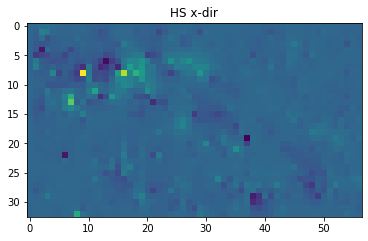

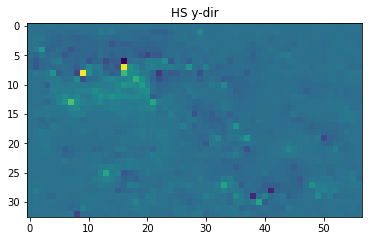

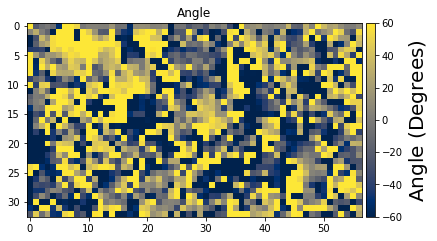

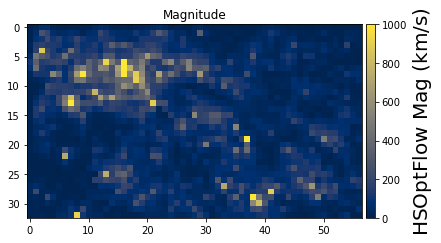

mean speeds > 0:  107.70355624988159


In [13]:
ind_pick = 0
example_reg1 = epoch1_reg[ind_pick]
example_reg2 = epoch2_reg[ind_pick]

#normalize...very basic style could be better
data_min = np.min(example_reg1) #epoch 1
data_max = np.max(example_reg1)
scaled_data1 = (example_reg1 - data_min) / (data_max - data_min)
data_min = np.min(example_reg2) #epoch 2
data_max = np.max(example_reg2)
scaled_data2 = (example_reg2 - data_min) / (data_max - data_min)

hs_arr = HornSchunck(np.flip(scaled_data1, axis=1),
                     np.flip(scaled_data2, axis=1))
plt.title('HS x-dir')
plt.imshow(hs_arr[0]) #x-direction
plt.show()
plt.title('HS y-dir')
plt.imshow(hs_arr[1]) #y-direction
plt.show()

#angle
fig, ax = plt.subplots(figsize=(6, 6))
flow_angles = np.arctan(hs_arr[1] / hs_arr[0]) * 180/np.pi
im = ax.imshow(flow_angles, vmin=-60, vmax=60, cmap='cividis')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax)
# cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm Angle~(Degrees)$', size=20)
ax.set_title('Angle')
plt.show()

#magnitude
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Magnitude')
interesting_flow = ((np.sqrt(hs_arr[1]**2. + hs_arr[0]**2.) * 0.12825 * 430.1 / 206265 * u.pc)/(11 * u.year)).to(u.km/u.s) # / np.max( np.sqrt(hs_arr[1]**2. + hs_arr[0]**2.))
im = ax.imshow(interesting_flow.value, cmap='cividis', vmin=0, vmax=1000)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax)
# cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm HSOptFlow~Mag~(km/s)$', size=20)
plt.show()

print('mean speeds > 0: ', np.mean(interesting_flow[interesting_flow.value > 0].value))

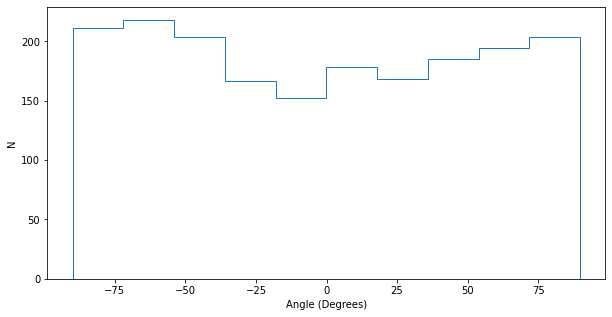

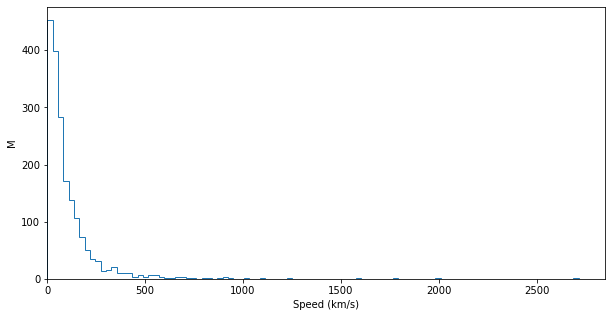

In [15]:
f, ax = plt.subplots(1, 1, figsize=(10,5))

# data = flow_angles.flatten()
# heights, bins = np.histogram(data, bins = 2000)
# percent = [i/sum(heights)*100 for i in heights]
# ax.bar(bins[:-1], percent, width=20, align="edge")
# vals = ax.get_yticks()
# ax.set_yticklabels(['%1.2f%%' %i for i in vals])

#looks neat but not sure if density=True gets what I want
from matplotlib.ticker import PercentFormatter
ax.hist(flow_angles.flatten(), histtype='step')
# plt.gca().yaxis.set_major_formatter(PercentFormatter(0.1))

# ax.plot([0, 2500], [0.0005, 0.0005])
# ax.set_ylim(0, .001)
ax.set_ylabel('N')
ax.set_xlabel('Angle (Degrees)')
plt.show()

f, ax = plt.subplots(1, 1, figsize=(10,5))

# data = interesting_flow.flatten()
# heights, bins = np.histogram(data, bins = 2000)
# percent = [i/sum(heights)*100 for i in heights]
# ax.bar(bins[:-1], percent, width=20, align="edge")
# vals = ax.get_yticks()
# ax.set_yticklabels(['%1.2f%%' %i for i in vals])

#looks neat but not sure if density=True gets what I want
from matplotlib.ticker import PercentFormatter
ax.hist(interesting_flow.value.flatten(), bins=100, histtype='step')
# plt.gca().yaxis.set_major_formatter(PercentFormatter(0.1))

# ax.plot([0, 2500], [0.0005, 0.0005])
# ax.set_ylim(0, .001)
ax.set_xlim(0, )
ax.set_ylabel('M')
ax.set_xlabel('Speed (km/s)')
plt.show()

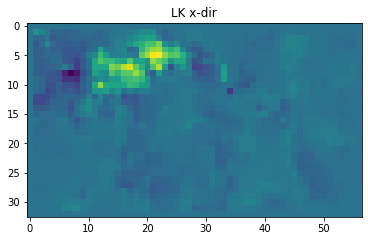

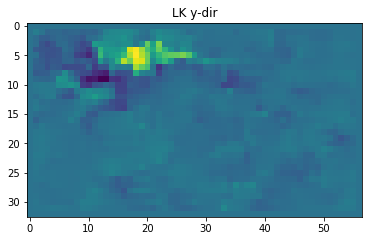

C:\Users\arubi\AppData\Local\Temp\ipykernel_26648\958377.py:24: RuntimeWarning: invalid value encountered in divide
  flow_angles = np.arctan(lk_arr[1] / lk_arr[0]) * 180/np.pi


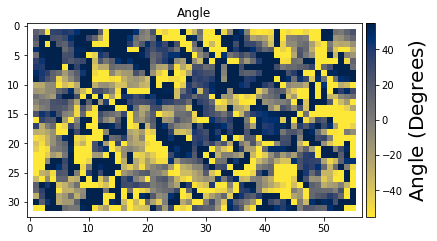

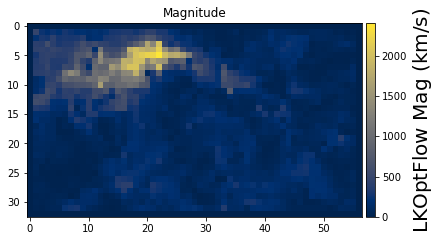

LK mean, whole box: 198.682557270849


In [16]:
ind_pick = 0
example_reg1 = epoch1_reg[ind_pick]
example_reg2 = epoch2_reg[ind_pick]

#normalize...very basic style could be better
data_min = np.min(example_reg1) #epoch 1
data_max = np.max(example_reg1)
scaled_data1 = (example_reg1 - data_min) / (data_max - data_min)
data_min = np.min(example_reg2) #epoch 2
data_max = np.max(example_reg2)
scaled_data2 = (example_reg2 - data_min) / (data_max - data_min)

lk_arr = LucaseKanade(np.flip(scaled_data1, axis=1), np.flip(scaled_data2, axis=1), 3, 1e-15)

plt.title('LK x-dir')
plt.imshow(lk_arr[0]) #x-direction
plt.show()
plt.title('LK y-dir')
plt.imshow(lk_arr[1]) #y-direction
plt.show()

#angle
fig, ax = plt.subplots(figsize=(6, 6))
flow_angles = np.arctan(lk_arr[1] / lk_arr[0]) * 180/np.pi
im = ax.imshow(flow_angles, vmin=-55, vmax=55, cmap='cividis_r')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax)
# cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm Angle~(Degrees)$', size=20)
ax.set_title('Angle')
plt.show()

#magnitude
n2071_dist = 1.234e16  #400 pc to km
pix_size = 0.12825 #for hst
time = 3.471e+8 #10 yrs to secs

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Magnitude')
interesting_flow = np.sqrt(lk_arr[1]**2. + lk_arr[0]**2.) *pix_size* n2071_dist/206265 / time
im = ax.imshow((interesting_flow), cmap='cividis')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax)
# cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm LKOptFlow~Mag~(km/s)$', size=20)
plt.show()

print('LK mean, whole box:', np.mean(interesting_flow))

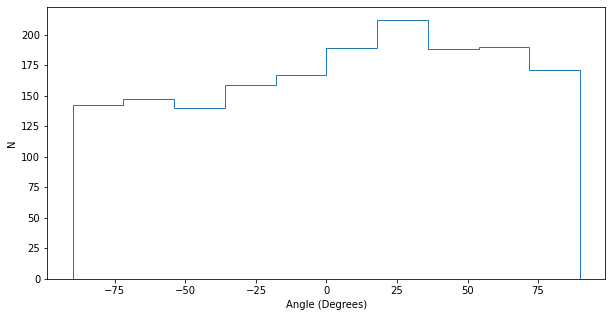

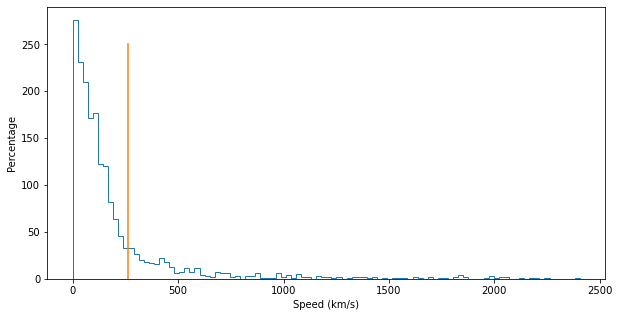

In [17]:
#angles
f, ax = plt.subplots(1, 1, figsize=(10,5))

# data = flow_angles.flatten()
# heights, bins = np.histogram(data, bins = 2000)
# percent = [i/sum(heights)*100 for i in heights]
# ax.bar(bins[:-1], percent, width=20, align="edge")
# vals = ax.get_yticks()
# ax.set_yticklabels(['%1.2f%%' %i for i in vals])

#looks neat but not sure if density=True gets what I want
from matplotlib.ticker import PercentFormatter
ax.hist(flow_angles.flatten(), histtype='step')
# plt.gca().yaxis.set_major_formatter(PercentFormatter(0.1))

# ax.plot([0, 2500], [0.0005, 0.0005])
# ax.set_ylim(0, .001)
ax.set_ylabel('N')
ax.set_xlabel('Angle (Degrees)')
plt.show()

#speeds
f, ax = plt.subplots(1, 1, figsize=(10,5))

# data = interesting_flow.flatten()
# heights, bins = np.histogram(data, bins = 2000)
# percent = [i/sum(heights)*100 for i in heights]
# ax.bar(bins[:-1], percent, width=20, align="edge")
# vals = ax.get_yticks()
# ax.set_yticklabels(['%1.2f%%' %i for i in vals])

#looks neat but not sure if density=True gets what I want
from matplotlib.ticker import PercentFormatter
ax.hist(interesting_flow.flatten(), bins=100, histtype='step')
# plt.gca().yaxis.set_major_formatter(PercentFormatter(0.1))

# ax.plot([0, 2500], [0.0005, 0.0005])
ax.plot([260, 260], [0, 250])
# ax.set_ylim(0, .001)
ax.set_ylabel('Percentage')
ax.set_xlabel('Speed (km/s)')
plt.show()

a final addition would be to add a pyramidal scheme, which would likely make this work a lot better when trying out larger or more complex patches